In [2]:
#!pip install opencv-python==4.5.5.64

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 8.0 MB/s eta 0:00:000m eta 0:00:010:00:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.2.54
    Uninstalling opencv-python-4.5.2.54:
      Successfully uninstalled opencv-python-4.5.2.54
Note: you may need to restart the kernel to use updated packages.


In [3]:
#!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 10.0 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached opencv_contrib_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.1 MB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.7 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached absl_py-1.2.0-py3-none-any.whl (123 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 10.3 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached fonttools-4.34.4-py3-none-any.whl (944 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached pyparsing-3.0.9-py3-none-any.

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import glob

In [63]:

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


def extract_keypoints(results):
    hand_label_result = dict()
    for hand in results.multi_handedness:
        hand_label_result[hand.classification[0].index] = hand.classification[0].label

    keypoints = []
    for hand in results.multi_hand_landmarks:
        hand_keypoints = []
        for point in range(21):
            landmark = hand.landmark[point]
            hand_keypoints.extend([landmark.x, landmark.y, landmark.z])
            
        keypoints.append(hand_keypoints)
        
    #print(len(keypoints))
    #print(hand_label_result)
    
    if len(keypoints) == 1:
        keypoints.append(list(np.zeros(len(keypoints[0]))))
    try:
        if hand_label_result[0] != 'Left':
            keypoints = keypoints[1] + keypoints[0]
        else:
            keypoints = keypoints[0] + keypoints[1]
    except:
        keypoints = keypoints[1] + keypoints[0]
    return keypoints

def dataset_path_labels():

    txtfiles = []
    labels = []
    files = []
    names = []
    for file in glob.glob("ASL-Text/videos/*"):
        label = file.split("/")[-1]
        
        for file_img in glob.glob(file + "/*/images/*.jpg"):
            name = file_img.split("/")[3]
            
            if names == []:
                names.append(name)
                #labels.append(label)
                
            if name in names:
                files.append(file_img)
                
            else:
                txtfiles.append(files)
                files = []
                names.append(name)
                labels.append(label)
                
                
    return txtfiles, labels

In [64]:
txtfiles, labels = dataset_path_labels()

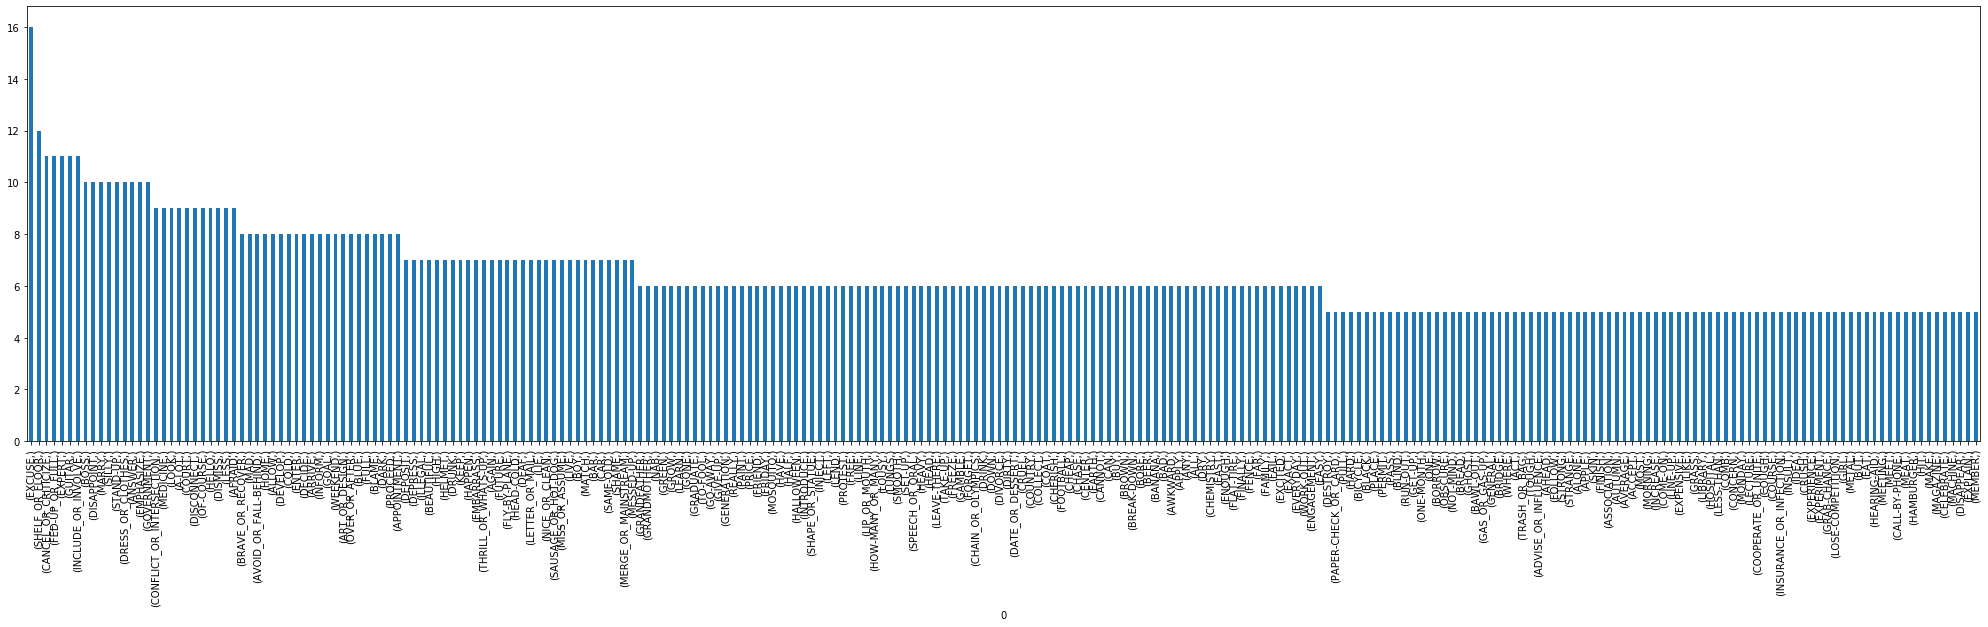

In [5]:
pd.DataFrame(labels).value_counts().plot.bar(figsize=(35, 8));

In [6]:
import matplotlib.pyplot as plt

In [13]:

keypoints = []

# For static images:
IMAGE_FILES = txtfiles

with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.45) as hands:
    
  
  for n, file_label in enumerate(IMAGE_FILES):
      #if n == 52:
      #   break
      keypoints_label = []
      for idx, file in enumerate(file_label):
        # Read an image, flip it around y-axis for correct handedness output (see
        # above).
        #image_flip = image.copy()
        image = cv2.flip(cv2.imread(file), 1)
        image = cv2.imread(file)
        # Convert the BGR image to RGB before processing.
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #results_flip = hands.process(cv2.cvtColor(image_flip, cv2.COLOR_BGR2RGB))

        # Print handedness and draw hand landmarks on the image.
        #print('Handedness:', results.multi_handedness)
        if not results.multi_hand_landmarks:
          continue
        keypoints_label.append(extract_keypoints(results))

        image_height, image_width, _ = image.shape
        annotated_image = image.copy()

        for hand_landmarks in results.multi_hand_landmarks:
          #print('hand_landmarks:', hand_landmarks)
          #print(
          #    f'Index finger tip coordinates: (',
          #    f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          #    f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
          #)
          mp_drawing.draw_landmarks(
              annotated_image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS,
              mp_drawing_styles.get_default_hand_landmarks_style(),
              mp_drawing_styles.get_default_hand_connections_style())
        
    
        #cv2.imwrite(
        #    'tmp/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))
        #annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        #plt.imshow(annotated_image)

        #plt.show()

        # Draw hand world landmarks.
        #if not results.multi_hand_world_landmarks:
        #  continue
        #for hand_world_landmarks in results.multi_hand_world_landmarks:
        #  mp_drawing.plot_landmarks(
        #    hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
      keypoints.append(np.array(keypoints_label))

In [65]:
len(labels)

1597

In [66]:
len(keypoints)

1597

In [38]:
keypoints[-1]

array([[ 4.92399395e-01,  4.04703259e-01, -8.62504450e-08, ...,
         5.52699625e-01,  5.20222187e-01, -2.09382344e-02],
       [ 4.91195351e-01,  4.03971463e-01, -1.49791404e-07, ...,
         5.51844835e-01,  5.19227266e-01, -2.01497041e-02],
       [ 4.89509225e-01,  4.08180356e-01, -1.18259507e-07, ...,
         5.51466465e-01,  5.22701740e-01, -2.01595202e-02],
       ...,
       [ 4.92505699e-01,  4.09165531e-01, -1.27362867e-07, ...,
         5.42716444e-01,  5.24871528e-01, -2.17857417e-02],
       [ 4.89617914e-01,  4.05225962e-01, -1.20244721e-07, ...,
         5.43449402e-01,  5.23157418e-01, -2.23919936e-02],
       [ 4.85961974e-01,  4.38443512e-01, -2.06494192e-07, ...,
         5.19893885e-01,  5.61497211e-01, -2.86484249e-02]])

In [68]:
with open('labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [14]:
import pickle
with open('labels_flip.pkl', 'wb') as f:
    pickle.dump(labels, f)
    
with open('keypoints_flip.pkl', 'wb') as f:
    pickle.dump(keypoints, f)

In [15]:
with open('keypoints.pkl', 'rb') as f:
    mynewlist = pickle.load(f)